# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Описание данных

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц.

Известно:  
**_сalls_** — количество звонков,  
**_minutes_** — суммарная длительность звонков в минутах,  
**_messages_** — количество sms-сообщений,  
**_mb_used_** — израсходованный интернет-трафик в Мб,  
**_is_ultra_** — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## Откройте и изучите файл

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
try:
    data = pd.read_csv('datasets/users_behavior.csv')  # Локальный путь
except:
    data = pd.read_csv('/datasets/users_behavior.csv')  # Серверный путь

In [3]:
data.head(5)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [4]:
data.isnull().sum()

calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [6]:
data['calls']=data['calls'].astype(int)
data['messages']=data['messages'].astype(int)

In [7]:
data.dtypes

calls         int64
minutes     float64
messages      int64
mb_used     float64
is_ultra      int64
dtype: object

Изучим данные на наличие мультиколлинеарности.

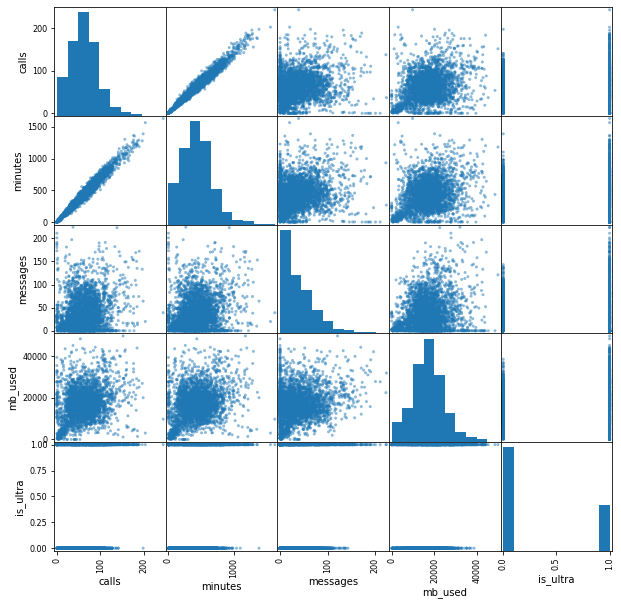

In [8]:
pd.plotting.scatter_matrix(data, figsize = (10,10))
plt.show()

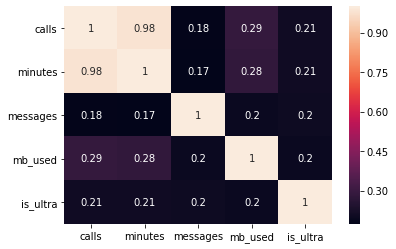

In [9]:
sns.heatmap(data.corr(), annot=True)
plt.show()

 ### Вывод:  
 - Данные обработали до конца - calls и messages задали типом int как количество
 - Null в данных нет
 - Наибольшая мультиколлинеарность выявлена между minutes и calls, что вполне логично, не будем использовать для построения модели или calls, или minutes один, например

## Разбейте данные на выборки

In [10]:
#С помощью train_test_split Разделим наш датасет на следующие выборки 
data_train, data_valid = train_test_split(data, test_size=0.4, random_state=12345)
data_valid, data_test = train_test_split(data_valid,test_size = 0.5, random_state=12345)
print('Размер обучающей выборки:', data_train.shape[0],'объектов')
print('Размер валидационной выборки:', data_valid.shape[0],'объекта')
print('Размер тестовой выборки:',data_test.shape[0],'объекта')

Размер обучающей выборки: 1928 объектов
Размер валидационной выборки: 643 объекта
Размер тестовой выборки: 643 объекта


In [11]:
train_features = data_train.drop(columns=['is_ultra', 'minutes'])
train_target = data_train.is_ultra

valid_features = data_valid.drop(columns=['is_ultra', 'minutes'])
valid_target = data_valid.is_ultra

test_features = data_test.drop(columns=['is_ultra', 'minutes'])
test_target = data_test.is_ultra

### Вывод:
* Разбили датасет на 3 части
* Методом перебора по качеству - качество лучше, если оставляем calls, убираем minutes (выяснено в дальнейшем, так и оставим - не хочется слишком загромождать работу кодом)

## Исследуйте модели

### Начнем с обычного решающего дерева.

In [12]:
best_model = None
best_depth = 0
best_result = 0
for depth in range(1, 6):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth) # обучите модель с заданной глубиной дерева
    model.fit(train_features, train_target) # обучите модель
    predictions = model.predict(valid_features) # получите предсказания модели
    result = accuracy_score(valid_target, predictions) # посчитайте качество модели
    if result > best_result:
        best_model_decision_tree = model
        best_result = result
        best_depth = depth
print("Accuracy лучшей модели:", best_result)
print("Глубина лучшей модели:", best_depth)

Accuracy лучшей модели: 0.7900466562986003
Глубина лучшей модели: 5


### Обучим случайный лес

In [13]:
best_model = None
best_estimators = 0
best_result = 0
best_depth = 0
for estimators in range(1, 100):
    for depth in range(1, 6):
        model = RandomForestClassifier(random_state=12345, n_estimators=estimators, max_depth=depth) 
        model.fit(train_features, train_target) 
        predictions = model.predict(valid_features) 
        result = accuracy_score(valid_target, predictions) 
        if result > best_result:
            best_model_random_forest = model
            best_result = result
            best_estimators = estimators
            best_depth = depth
print("Accuracy лучшей модели:", best_result)
print("Количество деревьев лучшей модели:", best_estimators)
print("Глубина лучшей модели:", best_depth)

Accuracy лучшей модели: 0.7931570762052877
Количество деревьев лучшей модели: 13
Глубина лучшей модели: 5


### Логистическая регрессия

In [14]:
model = LogisticRegression(random_state=12345)
model.fit(train_features, train_target) 
predictions = model.predict(valid_features) 
result = accuracy_score(valid_target, predictions)
print("Accuracy логистической регрессии:", result)

Accuracy логистической регрессии: 0.7511664074650077


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### Вывод:  
* Наилучшая модель - случайный лес с количеством деревьев, равным 13, глубиной = 5 и точностью 0.793
* Проверим эту модель на тестовой выборке

## Проверьте модель на тестовой выборке

In [15]:
features = pd.concat([train_features, valid_features])

In [16]:
target = pd.concat([train_target, valid_target])

In [17]:
model = RandomForestClassifier(random_state=12345, n_estimators=13, max_depth=5) 
model.fit(features, target) 
predictions = model.predict(test_features) 
result = accuracy_score(test_target, predictions) 
print("Accuracy лучшей модели случаного леса:", result)

Accuracy лучшей модели случаного леса: 0.7853810264385692


In [18]:
model = DecisionTreeClassifier(random_state=12345, max_depth=5) # обучите модель с заданной глубиной дерева
model.fit(features, target) # обучите модель
predictions = model.predict(test_features) 
result = accuracy_score(test_target, predictions) 
print("Accuracy лучшей модели обычного дерева:", result)

Accuracy лучшей модели обычного дерева: 0.7838258164852255


### Вывод:
* Accuracy лучших моделей, обученных по обучающей и валидационной выборки немного ухудшились, но при этом остались достаточно высокими - при этом accuracy случайного леса выше

## (бонус) Проверьте модели на адекватность

Сравним модель с предсказаниями **DummyClassifier**.

In [19]:
dummy_clf = DummyClassifier(strategy="prior")
dummy_clf.fit(train_features, train_target)
predictions = dummy_clf.predict(valid_features)
dummy_clf.score(predictions, valid_target)

0.7060653188180405

### Вывод:
* Так как accuracy модели случайного леса, полученная по трейн и валидационной выборке = 0.785 - модель адекватна  
* Accuracy нашей модели выше бейзлайна DummyClassifier

## Общий вывод:
* Обнаружили мультиколлинеарность между фичами - minutes и calls, убрали minutes
* Разбили датасет на три части, обучили три модели - обычное дерево, случайной лес и логистическую регрессию на одной train части
* Наилучшая модель - случайный лес с количеством деревьев, равным 13, глубиной = 5 и точностью 0.793
* Обучили модель на train + validation - на accuracy сказалось в понижающую сторону = 0.785
* Модель случайного леса адекватна - accuracy выше, чем в простом классификаторе Dummy или если проверять по балансу классов

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x] Jupyter Notebook открыт
- [x] Весь код исполняется без ошибок
- [x] Ячейки с кодом расположены в порядке исполнения
- [x] Выполнено задание 1: данные загружены и изучены
- [x] Выполнено задание 2: данные разбиты на три выборки
- [x] Выполнено задание 3: проведено исследование моделей
    - [x] Рассмотрено больше одной модели
    - [x] Рассмотрено хотя бы 3 значения гипепараметров для какой-нибудь модели
    - [x] Написаны выводы по результатам исследования
- [x] Выполнено задание 3: Проведено тестирование
- [x] Удалось достичь accuracy не меньше 0.75
